In [1]:
import pandas as pd
import joblib

def feature_engineering(df):
    user_features = df.groupby('msisdn').agg(
        total_calls=('msisdn', 'count'),
        outgoing_call_ratio=('call_direction', lambda x: (x == 'outgoing').sum() / len(x)),
        avg_duration=('duration', 'mean'),
        std_duration=('duration', 'std'),
        nocturnal_call_ratio=('hour_of_day', lambda h: ((h >= 22) | (h <= 6)).mean()),
        mobility=('cell_tower', 'nunique'),
        is_fraud=('is_fraud', 'first')
    ).reset_index()
    user_features.fillna(0, inplace=True)
    return user_features

def run_inference(model, new_data_df):
    print("Running inference with Random Forest model...")
    
    new_features_df = feature_engineering(new_data_df)
    
    X_new = new_features_df.drop(['msisdn', 'is_fraud'], axis=1)
    
    predictions = model.predict(X_new)
    prediction_proba = model.predict_proba(X_new)[:, 1]
    
    new_features_df['predicted_fraud'] = predictions
    new_features_df['fraud_probability'] = prediction_proba
    
    print("\nInference complete. Fraudulent users identified:")
    print(new_features_df[new_features_df['predicted_fraud'] == True][['msisdn', 'is_fraud', 'fraud_probability']])
    
    return new_features_df

if __name__ == '__main__':
    model_filename = 'fraud_detection_model_rf.joblib'
    inference_data_filename = '3G_cdr_data.csv'
    inference_output_filename = 'inference_results_rfc.csv'

    try:
        model = joblib.load(model_filename)
    except FileNotFoundError:
        print(f"Error: Model file not found at '{model_filename}'.")
        exit()
        
    try:
        new_raw_data = pd.read_csv(inference_data_filename)
    except FileNotFoundError:
        print(f"Error: Inference data file not found at '{inference_data_filename}'.")
        exit()
        
    inferred_results = run_inference(model, new_raw_data)
    
    total_inferred_users = len(inferred_results)
    fraudulent_count = int(inferred_results['predicted_fraud'].sum())
    print("\n--- Inference Summary ---")
    print(f"Total MSISDNs in inference dataset: {total_inferred_users}")
    print(f"Number of MSISDNs predicted as fraudulent: {fraudulent_count}")
    print("-------------------------")
    
    inferred_results.to_csv(inference_output_filename, index=False)
    print(f"\nInference results saved to '{inference_output_filename}'")

Running inference with Random Forest model...

Inference complete. Fraudulent users identified:
            msisdn  is_fraud  fraud_probability
35      6590000035      True                1.0
46      6590000046      True                1.0
67      6590000067      True                1.0
91      6590000091      True                1.0
106     6590000106      True                1.0
...            ...       ...                ...
199945  6590199945      True                1.0
199946  6590199946      True                1.0
199947  6590199947      True                1.0
199957  6590199957      True                1.0
199997  6590199997      True                1.0

[10000 rows x 3 columns]

--- Inference Summary ---
Total MSISDNs in inference dataset: 200000
Number of MSISDNs predicted as fraudulent: 10000
-------------------------

Inference results saved to 'inference_results_rfc.csv'


Visualizing the frauds from inference results in 2D...
2D Visualization saved to 'fraud_frauds_visualization_2d.png'


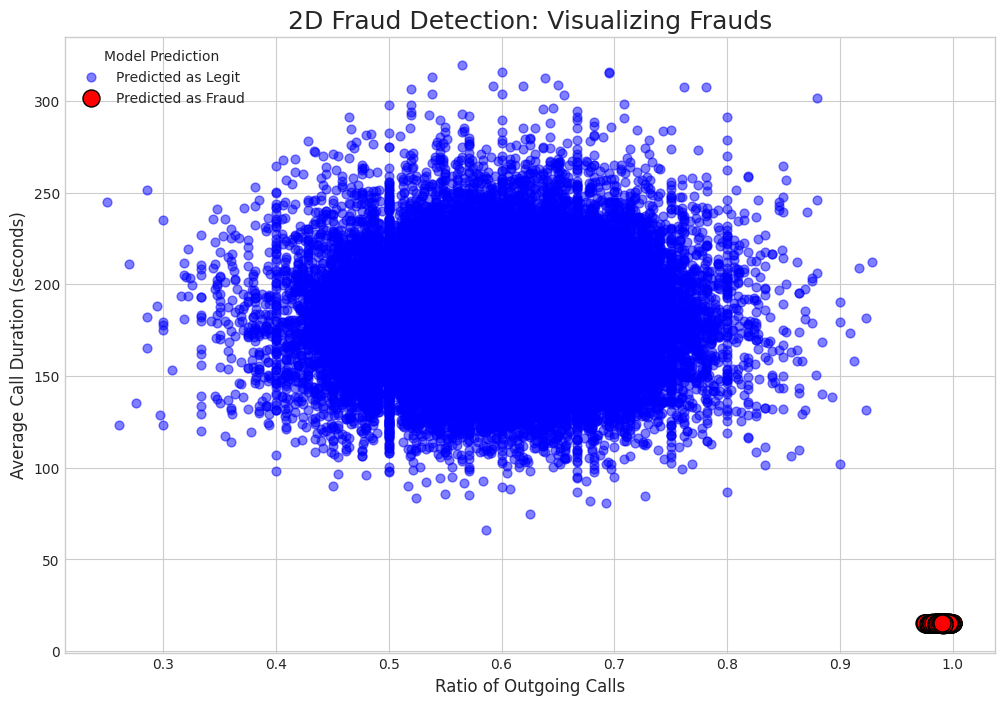

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_frauds_2d(inferred_df):
    """
    Creates a 2D scatter plot to visualize the separation of fraudulent and legitimate users.
    """
    print("Visualizing the frauds from inference results in 2D...")
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))
    
    predicted_legit = inferred_df[inferred_df['predicted_fraud'] == False]
    predicted_fraud = inferred_df[inferred_df['predicted_fraud'] == True]

    if not predicted_legit.empty:
        ax.scatter(predicted_legit['outgoing_call_ratio'], predicted_legit['avg_duration'],
                   c='blue', marker='o', s=40, alpha=0.5, label='Predicted as Legit')
    
    if not predicted_fraud.empty:
        ax.scatter(predicted_fraud['outgoing_call_ratio'], predicted_fraud['avg_duration'],
                   c='red', marker='o', s=150, label='Predicted as Fraud', edgecolor='k')

    ax.set_title('2D Fraud Detection: Visualizing Frauds', fontsize=18)
    ax.set_xlabel('Ratio of Outgoing Calls', fontsize=12)
    ax.set_ylabel('Average Call Duration (seconds)', fontsize=12)
    ax.legend(title='Model Prediction', fontsize=10)
        
    plot_filename = 'fraud_frauds_visualization_2d.png'
    plt.savefig(plot_filename, dpi=300)
    print(f"2D Visualization saved to '{plot_filename}'")
    plt.show()

if __name__ == '__main__':
    results_filename = 'inference_results_rfc.csv'
    
    try:
        inferred_df = pd.read_csv(results_filename)
    except FileNotFoundError:
        print(f"Error: Inference results file not found at '{results_filename}'.")
        print("Please run '04_infer_model_rfc.py' first.")
        exit()
        
    visualize_frauds_2d(inferred_df)
